# Linearization near an attractive fixed point

In this little Jupyter notebook, we'll illustrate the computation of the linerization conjugacy function for an attractive fixed point. That is, given a function an analytic function $f$ with an attractive fixed point at the origin, we wish to find and analytic function $\varphi$ such that 

$$\varphi\circ f(z) = L\circ\varphi(z).$$

The idea behind the construction is to define $\varphi_n(z) = \lambda^{-n}f^n(z)$, for then

$$\varphi_n\circ f = \lambda^{-n}f^{n+1} = \lambda \varphi_{n+1}.$$

Now, if $\varphi_n$ does converge to $\varphi$, then we must have

$$\varphi\circ f = \lambda \varphi = L\circ\varphi.$$

## Implementation

Here's an implementation. We'll use Just In Time compilation, since we want to generate an image.

In [14]:
0.8*np.exp(np.pi*1j/4)


(0.56568542494923812+0.56568542494923801j)

In [17]:
import numpy as np
from numba import jit

@jit
def phi(z):
    # Initialize
    llambda = 0.8*np.exp(np.pi*1j/4)
    zi = z
    cnt = 0
    # Iterate 100 times, unless the orbit escapes
    while cnt < 100 and zi.real*zi.real + zi.imag*zi.imag <= 4:
        zi = zi**2 + llambda*zi
        cnt = cnt+1
    if cnt == 100:
        # Scale back by 1/f'(0)^n
        return zi*(llambda)**(-100)
    else:
        # If the iterate escaped, then z is not in the domain of phi
        # so just return None
        return None

Here are a few values.

In [18]:
[phi(z) for z in [0, 0.1, 1-0.2j, 3+4j]]

[-0j, (0.11965056410343446+0.004672953528529853j), None, None]

## Generating an image

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt

In [20]:
# First, we'll generate the results of the phi function 
# throughout a grid in the complex plane

@jit
def generate(zmin,zmax):
    resolution = 1000
    xs = [zmin.real, zmax.real]
    xs.sort()
    xmin,xmax = xs
    ys = [zmin.imag, zmax.imag]
    ys.sort()
    ymin,ymax = ys
    xrange = xmax-xmin
    yrange = ymax-ymin
    if xrange >= yrange:
        xdim = int(resolution)
        ydim = int(xdim*(yrange/xrange))
        delta = xrange/xdim
    else:
        ydim = int(resolution)
        xdim = int(ydim*(xrange/yrange))
        delta = yrange/resolution

    phis = np.zeros((ydim,xdim), dtype='complex')
    for i in range(ydim):
        for j in range(xdim):
            z0 = complex(xmin + j*delta, ymin + i*delta)
            z = phi(z0)
            phis[i,j] = z #np.floor(3*np.angle(z)/np.pi)
    return phis
phis = generate(-1.1-1.1j,1.6+1.1j)

# Next, we'll lump the arguments of the resulting phi values into discrete clumps.
angles = np.array(list(map(lambda z: np.floor(4*np.angle(z)/np.pi), phis)))

# We'll do the same thing with the aboslute values, 
# after clipping, since they vary widely
def absclip(z):
    absz = abs(10*z)
    if absz<5:
        return np.floor(absz)
    else:
        return 20
def map_level(f, item, level):
    if level == 0:
        return f(item)
    else:
        return [map_level(f, i, level - 1) for i in item]
abss = map_level(absclip, phis,2)

TypeError: expected complex128, got None

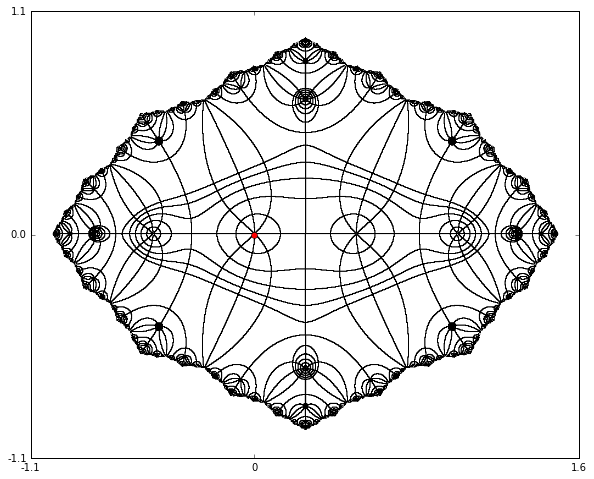

In [7]:
# Now, we're going to convolve the angle and absolute value clumps,
from scipy.ndimage import convolve
zmin = -1.1-1.1j
zmax = 1.6+1.1j
yres,xres = phis.shape[:2]
abs_convolved = convolve(abss, [[1,1,1],[1,-8,1],[1,1,1]])
abs_convolved = np.abs(np.sign(np.abs(abs_convolved)))
angle_convolved = convolve(angles, [[1,1,1],[1,-8,1],[1,1,1]])
angle_convolved = np.abs(np.sign(np.abs(angle_convolved)))

# add those results together,
both = abs_convolved + angle_convolved

# And show the results
plt.imshow(np.sign(both), cmap='Greys')
plt.plot([0,xres, xres,0,0], [0, 0, yres, yres, 0], 'k')

# This scaler function translates from the complex plane to our image space.
def scaler(domain_min, domain_max, range_min, range_max):
    def scale(x):
        return (-domain_min*range_max + domain_max*range_min + \
            (range_max - range_min)*x)/(domain_max - domain_min)
    return scale
xscale = scaler(-1.1,1.6, 0,1000)
yscale = scaler(-1.1,1.1, 0,814)
ax = plt.gca()
ax.set_xlim(0,xres)
ax.set_ylim(0,yres)
ax.set_yticks([0,yres/2,yres])
ax.set_yticklabels([zmin.imag, (zmax.imag+zmin.imag)/2, zmax.imag])
ax.set_xticks([0,xscale(0),xres])
supress = ax.set_xticklabels([zmin.real, 0, zmax.real])
plt.plot(xscale(0), yscale(0), 'ro')

fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(12)

The red point is the origin. The curves emanating out of that point map to rays of constant argument under $\varphi$; the loops around that point (only one is explicit) map to circles of constant absolute value. There are many other points that have the same general appearance as the origin; those are pre-images of the origin under $f$ or $f^n$ for some $n$. Put another way, those points eventually map onto the origin under iteration of $f$. As we move away from the origin, the curves congregate on the Julia set of $f$. Outside of the Julia set appears blank as that's outside the domain of $\varphi$.